# CS 282
### Programming Assignment 1
#### Item 7

Jan Lendl R. Uy

2019-00312

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def read_images(base_names):
    """Read multiple cameraman images"""
    images = []
    for name in base_names:
        img = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
        else:
            print(f"Error reading {name}")
    return images

In [4]:
def compute_fourier_spectrum(image):
    """
    Compute and return magnitude and phase spectrum
    Returns log magnitude for better visualization
    """
    f_transform = np.fft.fft2(image)
    f_shift = np.fft.fftshift(f_transform)
    
    magnitude = np.abs(f_shift)
    # Add small constant to avoid log(0)
    magnitude_spectrum = np.log1p(magnitude)
    
    phase = np.angle(f_shift)
    
    return magnitude_spectrum, phase

In [5]:
def display_fourier_analysis(images, titles):
    """
    Display original images with their Fourier magnitude and phase spectra
    """
    n_images = len(images)
    fig, axes = plt.subplots(n_images, 3, figsize=(15, 5*n_images))
    
    if n_images == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (img, title) in enumerate(zip(images, titles)):
        # Compute Fourier spectra
        magnitude_spectrum, phase_spectrum = compute_fourier_spectrum(img)
        
        # Original image
        axes[idx, 0].imshow(img, cmap='gray')
        axes[idx, 0].set_title(f'{title}\nOriginal Image')
        axes[idx, 0].axis('off')
        
        # Magnitude spectrum
        mag_display = axes[idx, 1].imshow(magnitude_spectrum, cmap='gray')
        axes[idx, 1].set_title('Magnitude Spectrum\n(log scale)')
        axes[idx, 1].axis('off')
        plt.colorbar(mag_display, ax=axes[idx, 1])
        
        # Phase spectrum
        phase_display = axes[idx, 2].imshow(phase_spectrum, cmap='gray')
        axes[idx, 2].set_title('Phase Spectrum')
        axes[idx, 2].axis('off')
        plt.colorbar(phase_display, ax=axes[idx, 2])
    
    plt.tight_layout()
    plt.show()

## Verify translation property

Verifying Translation Property...


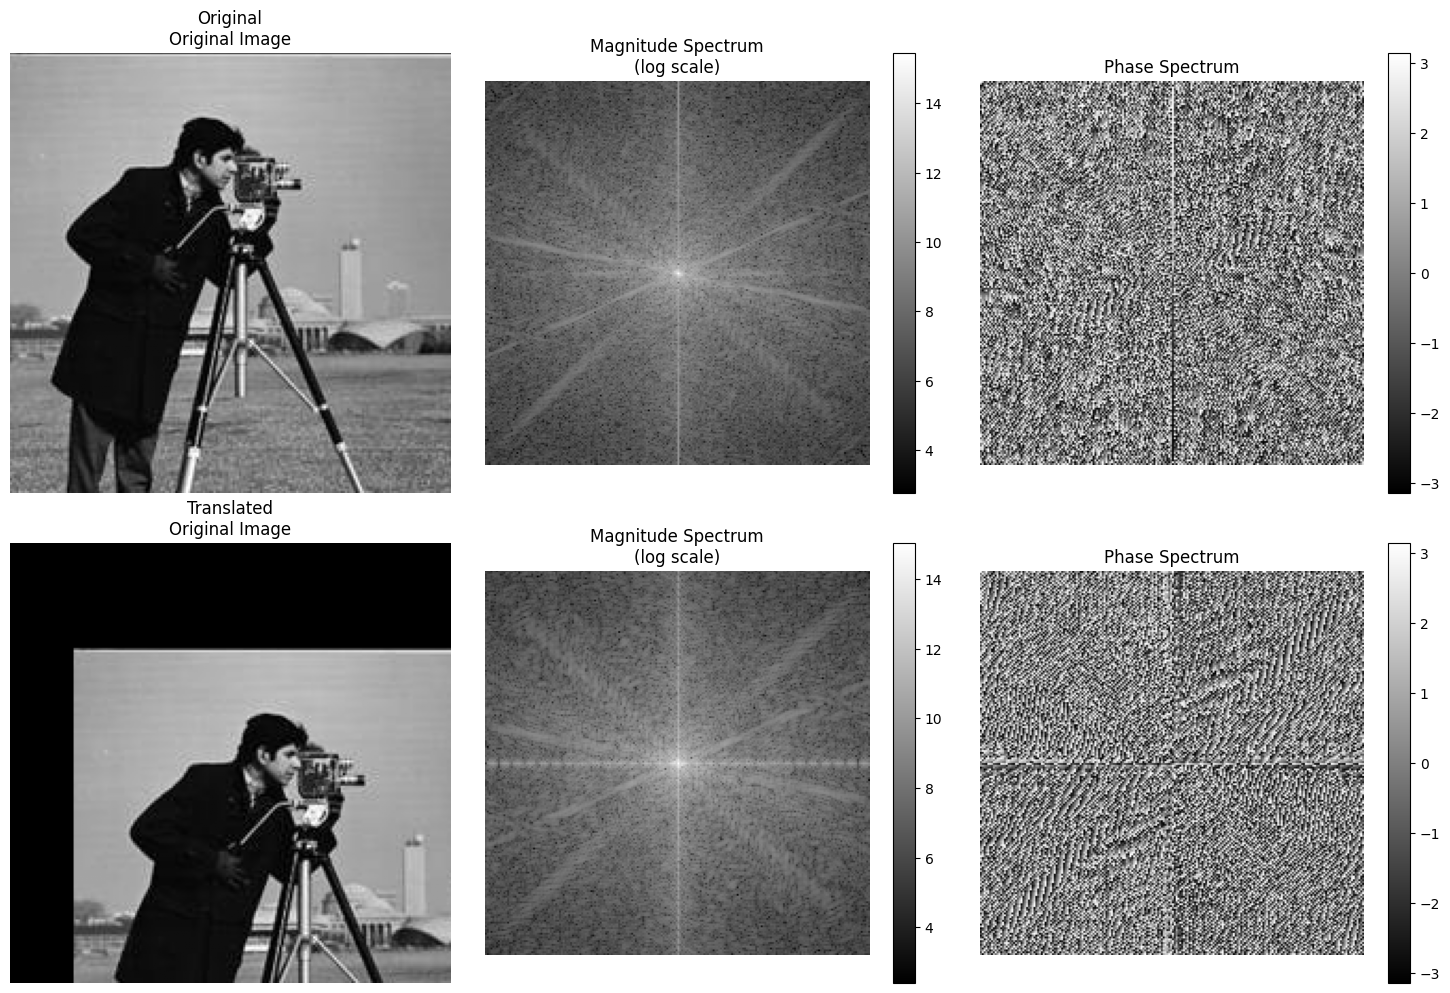

Translation Property Analysis:
- The magnitude spectra should be identical
- The phase spectra should differ due to the exp(-j2π(ux+vy)/M) factor
- This demonstrates that translation only affects phase


In [8]:
print("Verifying Translation Property...")

# Read original image
img = cv2.imread('images/cameraman1.jpg', cv2.IMREAD_GRAYSCALE)

# Create translated version using translation matrix
rows, cols = img.shape
M = np.float32([[1, 0, 30], [0, 1, 50]])  # Translate 30 pixels right, 50 pixels down
translated = cv2.warpAffine(img, M, (cols, rows))

display_fourier_analysis([img, translated], 
                        ['Original', 'Translated'])

print("Translation Property Analysis:")
print("- The magnitude spectra should be identical")
print("- The phase spectra should differ due to the exp(-j2π(ux+vy)/M) factor")
print("- This demonstrates that translation only affects phase")

## Verify rotation property


Verifying Rotation Property...


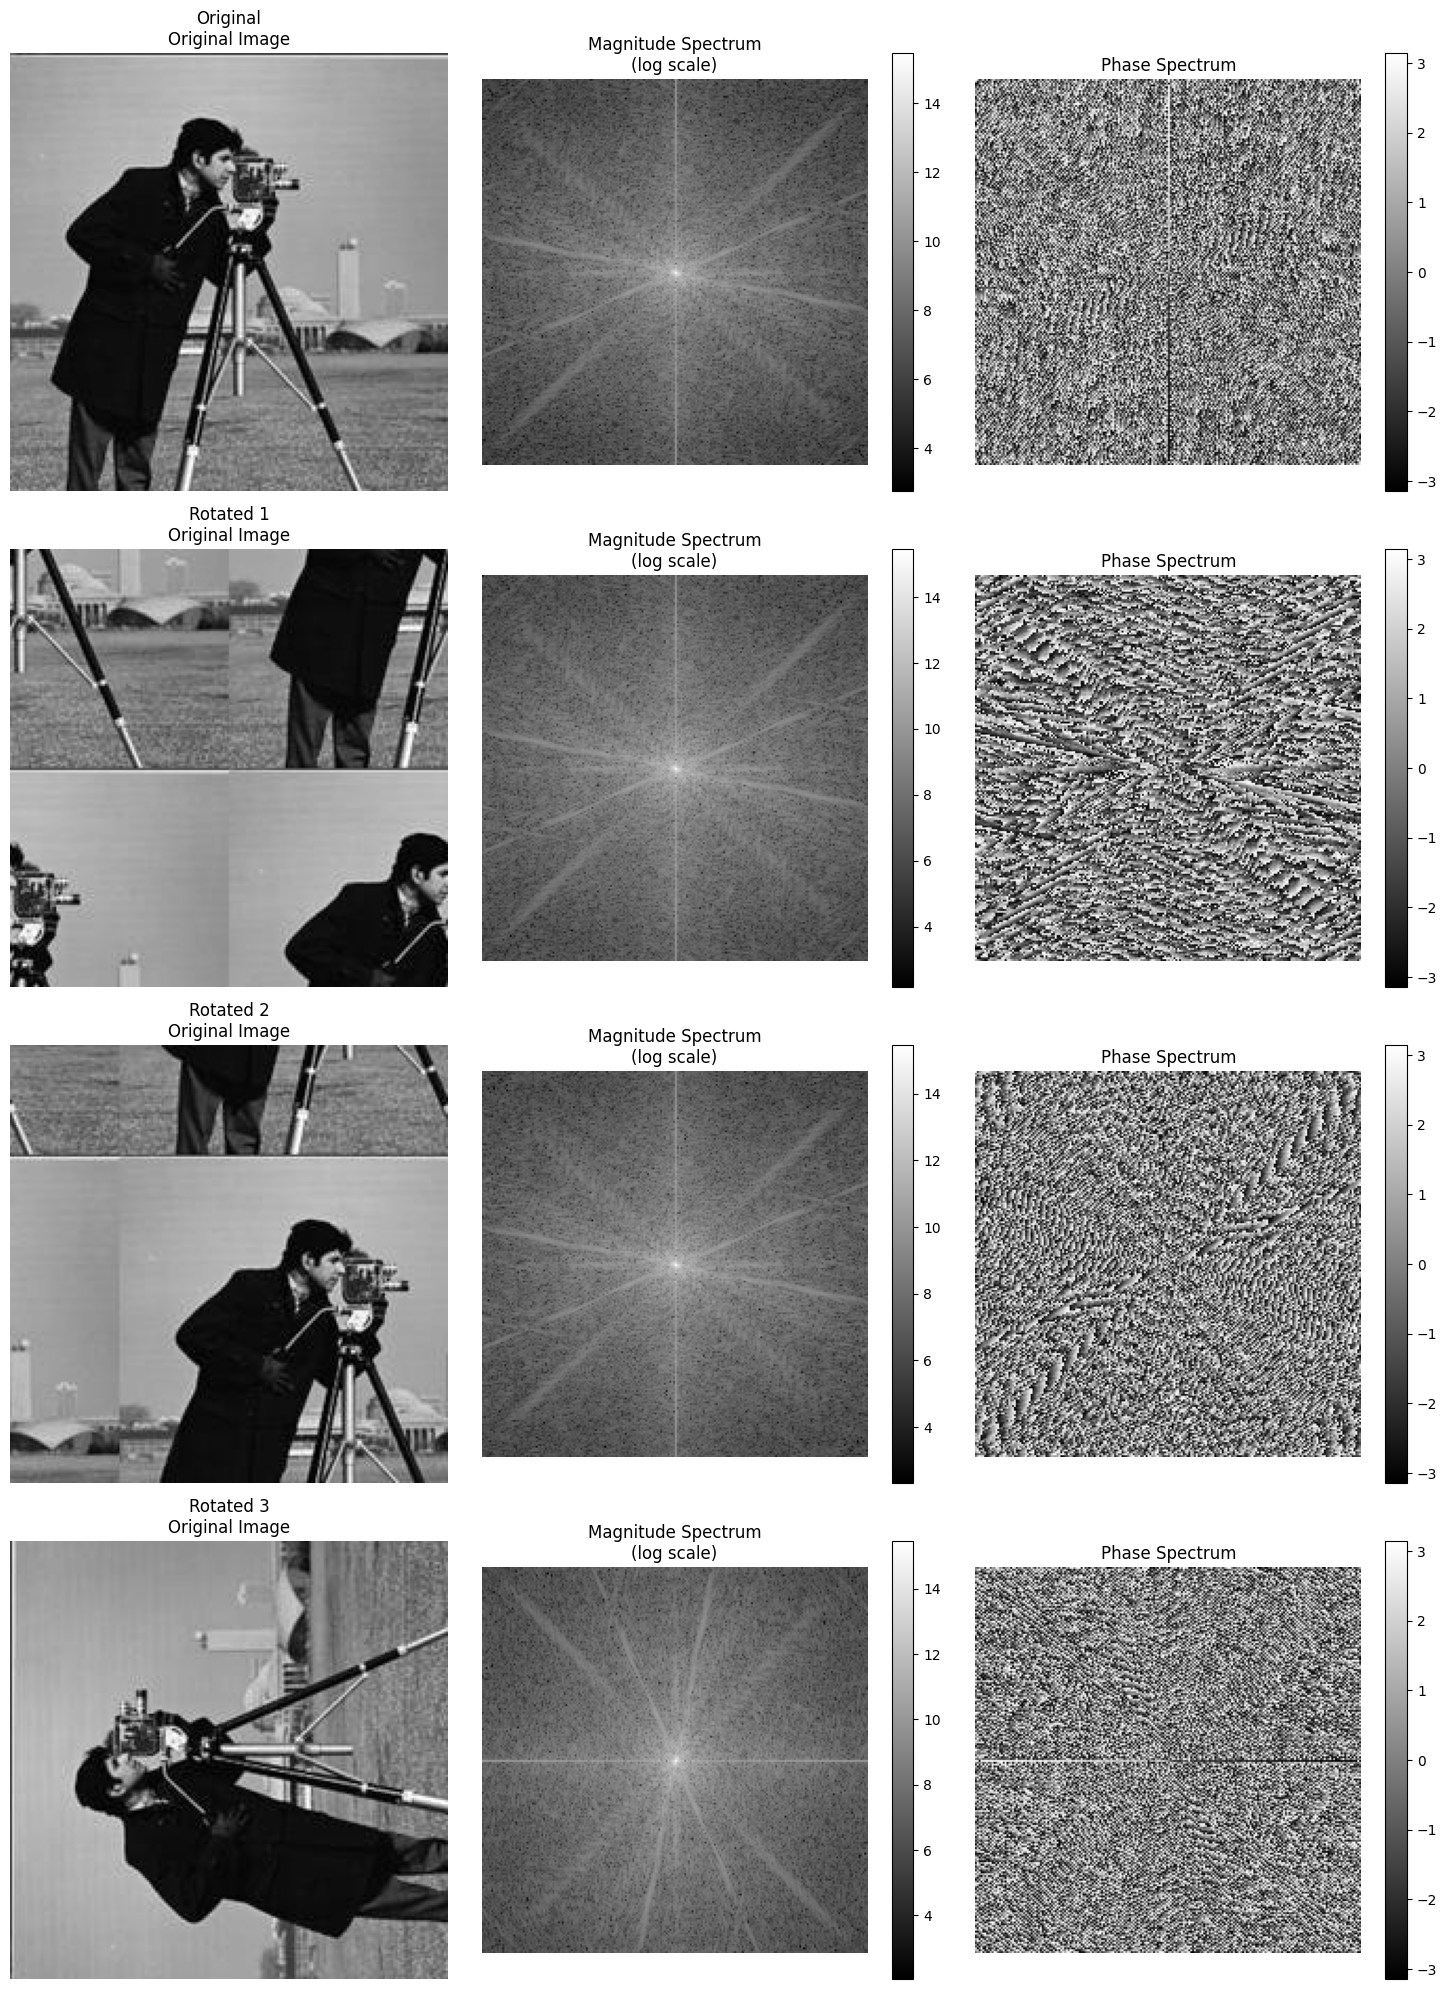

Rotation Property Analysis:
- Both magnitude and phase spectra are rotated
- The rotation angle in frequency domain matches spatial domain
- Pattern of frequency components rotates with the image


In [7]:
print("\nVerifying Rotation Property...")

# Read images
images = read_images(
    [
        "images/cameraman1.jpg",
        "images/cameraman2.jpg", 
        "images/cameraman3.jpg",
        "images/cameraman4.jpg"
    ]
)

display_fourier_analysis(images, 
                        ['Original', 'Rotated 1', 'Rotated 2', 'Rotated 3'])

print("Rotation Property Analysis:")
print("- Both magnitude and phase spectra are rotated")
print("- The rotation angle in frequency domain matches spatial domain")
print("- Pattern of frequency components rotates with the image")